In [74]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import glob

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [2]:
DATASET_ROOT = '/home/raid_storage/datasets/rosatom'
OUT_IMAGES_FOLDER = os.path.join(DATASET_ROOT, 'sam', 'images')
OUT_MASKS_FOLDER = os.path.join(DATASET_ROOT, 'sam', 'masks')
OUT_OVERLAPPED_FOLDER = os.path.join(DATASET_ROOT, 'sam', 'overlapped')

CSV_PATH = os.path.join(DATASET_ROOT, 'full_dataset.csv')

name2label = {
    "не дефект": 0,
    "потертость": 1,
    "черная точка": 2,
    "плена": 3,
    "маркер": 4,
    "грязь": 5,
    "накол": 6,
    "н.д. накол": 7,
    "микровыступ": 8,
    "н.д. микровыступ": 9,
    "вмятина": 10,
    "мех.повреждение": 11,
    "риска": 12,
    "царапина с волчком": 13
}
label2name = {v:k for k,v in name2label.items()}

In [31]:
df = pd.read_csv(CSV_PATH, index_col=0)
df

,filename,x,y,class
0,FRAMES/0/1538/frame0006.bmp,809,336,3
1,FRAMES/0/1538/frame0006.bmp,601,299,0
2,FRAMES/0/1538/frame0007.bmp,667,318,3
3,FRAMES/0/1538/frame0007.bmp,811,523,3
4,FRAMES/0/1538/frame0007.bmp,445,300,0
...,...,...,...,...
33572,FRAMES/2023.10.25/5_896.bmp,121,418,1
33573,FRAMES/2023.10.25/5_896.bmp,568,94,0
33574,FRAMES/2023.10.25/5_896.bmp,509,153,0
33575,FRAMES/2023.10.25/5_896.bmp,509,330,0


In [58]:
df_cleared = df[df['class'] != 0]
u_paths = df_cleared['filename'].unique()

stratify_dict = {}
stratify_list = []
for u_path in tqdm(u_paths):
    s_label = df_cleared[df_cleared['filename'] == u_path]['class'].values
    s = s_label.tolist()
    s.sort()
    stratify_dict[u_path] = ''.join([str(x) for x in s])
    stratify_list.append(' '.join([str(x) for x in s]))
    
df_str = pd.DataFrame({'filename': u_paths, 'stratify': stratify_list})

100%|██████████| 4640/4640 [00:05<00:00, 784.59it/s]


In [96]:
counter_df = df_str.groupby('stratify').agg({'filename': 'count'})
split_df = counter_df[counter_df['filename'] > 1]
split_df = split_df.reset_index()


to_split_df = df_str[df_str['stratify'].isin(split_df['stratify'].values)]
to_split_df.shape

(4540, 2)

In [97]:
split_df = counter_df[counter_df['filename'] == 1]
split_df = split_df.reset_index()


to_concat_df = df_str[df_str['stratify'].isin(split_df['stratify'].values)]
to_concat_df.shape

(100, 2)

In [98]:
df_train, df_test = train_test_split(
    to_split_df, 
    test_size=0.2, 
    random_state=17, 
    stratify=to_split_df['stratify'].values,
)

In [107]:
path_train = df_train['filename'].values.tolist() + to_concat_df['filename'].values.tolist()
len(path_train)

3732

In [108]:
path_test = df_test['filename'].values.tolist() 
len(path_test)

908

In [109]:
len(path_train) + len(path_test)

4640

In [110]:
df_cleared['stage'] = df_cleared['filename'].apply(lambda x: 'train' if x in path_train else 'test')
df_cleared

/tmp/ipykernel_2557/3970728979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleared['stage'] = df_cleared['filename'].apply(lambda x: 'train' if x in path_train else 'test')


,filename,x,y,class,stage
0,FRAMES/0/1538/frame0006.bmp,809,336,3,train
2,FRAMES/0/1538/frame0007.bmp,667,318,3,train
3,FRAMES/0/1538/frame0007.bmp,811,523,3,train
7,FRAMES/0/1538/frame0009.bmp,576,313,3,test
8,FRAMES/0/1538/frame0009.bmp,724,509,3,test
...,...,...,...,...,...
33565,FRAMES/2023.10.25/5_882.bmp,251,449,1,test
33569,FRAMES/2023.10.25/5_896.bmp,745,100,1,train
33570,FRAMES/2023.10.25/5_896.bmp,750,395,1,train
33571,FRAMES/2023.10.25/5_896.bmp,128,105,1,train


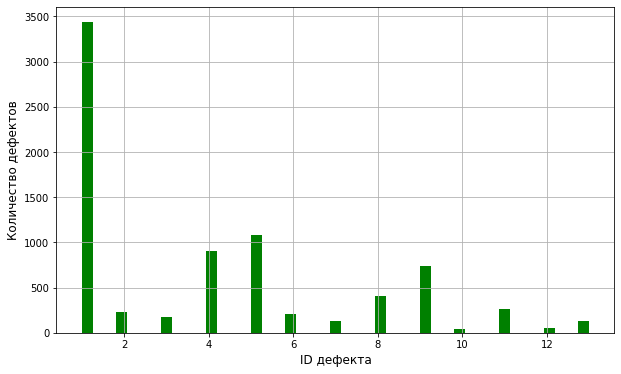

In [113]:
plt.figure(figsize=(10, 6))

plt.xlabel('ID дефекта', fontsize=12)
plt.ylabel('Количество дефектов', fontsize=12)
plt.hist(df_cleared[df_cleared['stage'] == 'train']['class'], 45, facecolor='g')
plt.grid(True)
plt.show()

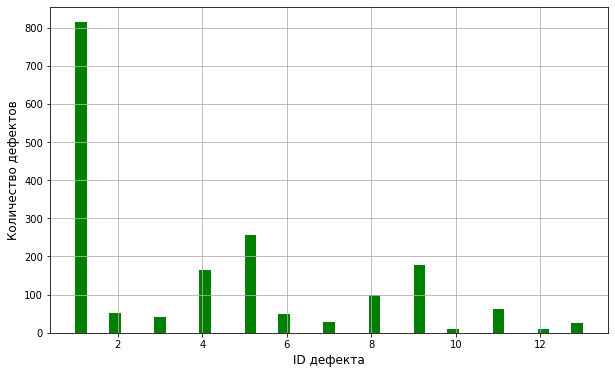

In [114]:
plt.figure(figsize=(10, 6))

plt.xlabel('ID дефекта', fontsize=12)
plt.ylabel('Количество дефектов', fontsize=12)
plt.hist(df_cleared[df_cleared['stage'] == 'test']['class'], 45, facecolor='g')
plt.grid(True)
plt.show()

In [115]:
set(path_train).intersection(path_test).__len__()

0

In [117]:
df_cleared.to_csv(os.path.join(DATASET_ROOT, 'filtered_data.csv'))